# Class Imbalance

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cup98_modeling_data_sample.csv')

#for this demonstration, we will only consider a few engineered features

df=df[['log_days_since_last',
 'RFA_2F',
 'RAMNTALL',
 'OCC1',
 'NUMPRM12',
 'MAXRAMNT',
 'EC6',
 'CARDPROM',
 'log_MAXRAMNT',
 'VC4',
 'RP4',
 'PEPSTRFL_ind',
 'OCC8',
 'NGIFTALL',
 'MINRAMNT',
 'EC2',
 'CONTROLN',
 'CARDPM12','TARGET_B']]

r,c = df.shape
print(" Dataset has {} rows and {} columns".format(r,c))
df.head()

 Dataset has 28606 rows and 19 columns


,log_days_since_last,RFA_2F,RAMNTALL,OCC1,NUMPRM12,MAXRAMNT,EC6,CARDPROM,log_MAXRAMNT,VC4,RP4,PEPSTRFL_ind,OCC8,NGIFTALL,MINRAMNT,EC2,CONTROLN,CARDPM12,TARGET_B
0,2.628389,1,180.0,14,14,60.0,8,20,1.778158,0,88,0.0,8,5,20.0,9,100339,5,0
1,2.713491,1,46.0,7,13,20.0,1,17,1.301052,1,17,0.0,5,5,5.0,17,45963,6,0
2,2.738781,1,20.0,9,10,20.0,7,6,1.301052,9,57,0.0,8,1,20.0,10,15689,4,0
3,2.738781,1,112.0,19,13,26.0,8,25,1.414990,17,91,1.0,11,7,5.0,16,74149,6,0
4,2.082785,1,40.0,18,14,15.0,8,9,1.176120,10,96,0.0,12,3,10.0,9,187162,4,0


<AxesSubplot:xlabel='index', ylabel='proportion'>

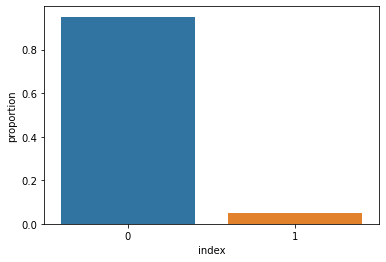

In [3]:
#check for imbalance

k=(df['TARGET_B']
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
)
sns.barplot(data=k, x='index', y='proportion')

In [4]:
#Create x and y then split into train and test

from sklearn.model_selection import train_test_split

X = df.drop(['TARGET_B'], axis=1)
y= df['TARGET_B'].rename('target')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


## scaling our data

from sklearn.preprocessing import StandardScaler

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)

X_train_std.shape

(20024, 18)

# Training a Binary Classifier

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
logmodel1 = LogisticRegression(C= 0.01, penalty="l1", solver='liblinear')
logmodel1.fit(X_train_std, y_train)


LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

# Performance Measures

# Measuring Accuracy Using Cross-Validation

In [7]:
from sklearn.model_selection import cross_val_score

score1 = cross_val_score(logmodel1, X_train_std, y_train, cv=5, scoring='accuracy')
score2 = cross_val_score(logmodel1, X_test_std, y_test, cv=5, scoring='accuracy')

print("Cross-validation Accuracy on Train Data: %.2f%%" % (score1.mean()* 100.0))
print("Cross-validation Accuracy on Test Data: %.2f%%" % (score2.mean()* 100.0))

Cross-validation Accuracy on Train Data: 95.11%
Cross-validation Accuracy on Test Data: 95.16%


# ROC AUC

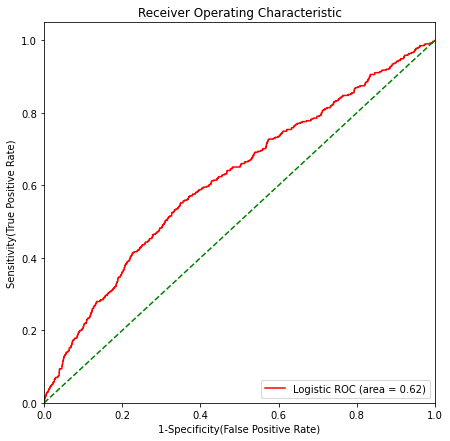

In [8]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Calculate Area under the curve to display on the plot
plt.figure(figsize=(7,7)) 


lr_probs1 = logmodel1.predict_proba(X_test_std)
probs1 = lr_probs1[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)

auc1 = roc_auc_score(y_test, probs1)
plt.plot(fpr1, tpr1, color='r', label='%s ROC (area = %0.2f)' % ('Logistic', auc1))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display


# HANDLING CLASS IMBALANCE

# 1. Oversampling 

In [9]:
from imblearn.over_sampling import RandomOverSampler

In [10]:
ros = RandomOverSampler(sampling_strategy='minority')
X_osample, y_osample=ros.fit_resample(X_train_std, y_train)
X_osample.shape

(38090, 18)

<AxesSubplot:title={'center':'Count of Classes'}>

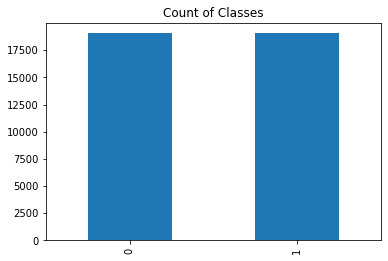

In [11]:
y_osample.value_counts().plot(kind='bar', title='Count of Classes')

In [12]:
##build a model on oversampled data
logmodel2 = LogisticRegression(C= 0.01, penalty="l1", solver='liblinear')
logmodel2.fit(X_osample, y_osample)

#IMPORTANT... we are making predictions on the original data, not an oversampled test dataset!!!
lr_probs2 = logmodel2.predict_proba(X_test_std)
probs2 = lr_probs2[:, 1]

# 2. UnderSampling

(1958, 18)


<AxesSubplot:title={'center':'Count of Classes'}>

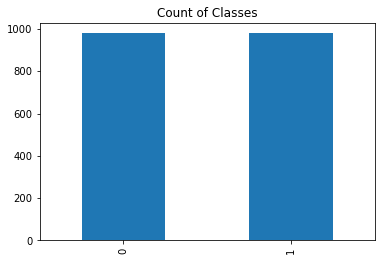

In [13]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_usample, y_usample=rus.fit_resample(X_train_std, y_train)
print(X_usample.shape)
y_usample.value_counts().plot(kind='bar', title='Count of Classes')

In [20]:
##build a model on undersampled data
logmodel3 = LogisticRegression(C= 0.01, penalty="l1", solver='liblinear')
logmodel3.fit(X_usample, y_usample)

#IMPORTANT... we are making predictions on the original data, not an undersampled test dataset!!!
lr_probs3 = logmodel3.predict_proba(X_test_std)
probs3 = lr_probs3[:, 1]


# 3. SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

(38090, 18)


<AxesSubplot:title={'center':'Count of Classes'}>

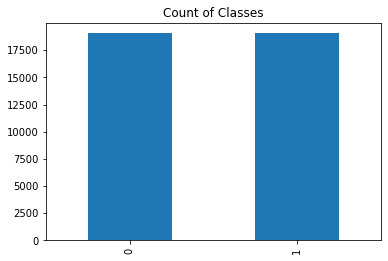

In [15]:
smote = SMOTE(random_state=42, k_neighbors=100)
X_ssample, y_ssample=smote.fit_resample(X_train_std, y_train)

print(X_ssample.shape)

y_ssample.value_counts().plot(kind='bar', title='Count of Classes')

In [16]:
##build a model on SMOTE data
logmodel4 = LogisticRegression(C= 0.01, penalty="l1", solver='liblinear')
logmodel4.fit(X_ssample, y_ssample)

#IMPORTANT... we are making predictions on the original data
lr_probs4 = logmodel4.predict_proba(X_test_std)
probs4 = lr_probs4[:, 1]

# 4. Class Weight

In [17]:
from sklearn.utils.class_weight import compute_class_weight
# Create class weights to counter-balance classification during training

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)

class_weights = {k: v for k, v in zip(classes, weights)}
print('Class weights:', class_weights)

Class weights: {0: 0.5257022840640588, 1: 10.226762002042902}


In [18]:
##build a weighted model
logmodel5 = LogisticRegression(C= 0.01, penalty="l1", solver='liblinear', class_weight='balanced')
logmodel5.fit(X_train_std, y_train)

#IMPORTANT... we are making predictions on the original data
lr_probs5 = logmodel5.predict_proba(X_test_std)
probs5= lr_probs5[:, 1]

# Evaluate the 5 models

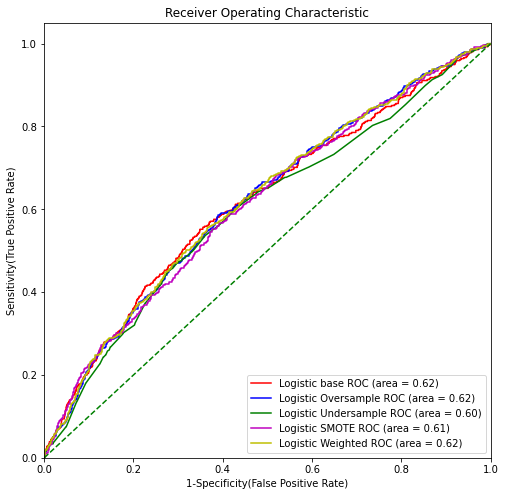

In [21]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probs2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, probs3)
fpr4, tpr4, thresholds4 = roc_curve(y_test, probs4)
fpr5, tpr5, thresholds5 = roc_curve(y_test, probs5)


# Calculate Area under the curve to display on the plot
plt.figure(figsize=(8,8)) 

auc1 = roc_auc_score(y_test, probs1)
plt.plot(fpr1, tpr1, color='r', label='%s ROC (area = %0.2f)' % ('Logistic base', auc1))
auc2 = roc_auc_score(y_test, probs2)
plt.plot(fpr2, tpr2, color='b', label='%s ROC (area = %0.2f)' % ('Logistic Oversample', auc2))
auc3 = roc_auc_score(y_test, probs3)
plt.plot(fpr3, tpr3, color='g', label='%s ROC (area = %0.2f)' % ('Logistic Undersample', auc3))
auc4 = roc_auc_score(y_test, probs4)
plt.plot(fpr4, tpr4, color='m', label='%s ROC (area = %0.2f)' % ('Logistic SMOTE', auc4))
auc5 = roc_auc_score(y_test, probs5)
plt.plot(fpr5, tpr5, color='y', label='%s ROC (area = %0.2f)' % ('Logistic Weighted', auc5))


# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

# Evaluate on Lift

In [ ]:
def gains_charts():
    ##create deciles and define buyers and nonbuyers
    predictions1['decile'] = pd.qcut(predictions1['proba'],10,labels=['10','9','8','7','6','5','4','3','2','1'])
    predictions1['nonbuyer'] = 1-predictions1['buyer']
    
    df1 = pd.pivot_table(data=predictions1,index=['decile'],values=['buyer','nonbuyer','proba'],
                     aggfunc={'buyer':[np.sum],
                              'nonbuyer':[np.sum],
                              'proba' : [np.mean]})
    df1.reset_index()
    
    df1.columns = ['buyer_Count','nonbuyer_Count','avg_score']
    df1['Total_Cust'] = df1['buyer_Count']+df1['nonbuyer_Count']
    
    df2 = df1.sort_values(by='avg_score',ascending=False)
    
    df2['buyer_rate'] = (df2['buyer_Count'] / df2['Total_Cust']).apply('{0:.2%}'.format)

    buyer_sum = df2['buyer_Count'].sum()
    nonbuyer_sum = df2['nonbuyer_Count'].sum()

    df2['buyer %'] = (df2['buyer_Count']/buyer_sum).apply('{0:.2%}'.format)
    df2['nonbuyer %'] = (df2['nonbuyer_Count']/nonbuyer_sum).apply('{0:.2%}'.format)
    
    df2['ks_stats'] = np.round(((df2['buyer_Count'] / df2['buyer_Count'].sum()).cumsum() -(df2['nonbuyer_Count'] / df2['nonbuyer_Count'].sum()).cumsum()), 4) * 100
    
    flag = lambda x: '*****' if x == df2['ks_stats'].max() else ''
    df2['max_ks'] = df2['ks_stats'].apply(flag)
    
    df2['buyer_cum%'] = np.round(((df2['buyer_Count'] / df2['buyer_Count'].sum()).cumsum()), 4) * 100
    
    df2['Base %'] = [10,20,30,40,50,60,70,80,90,100]
    
    overall = df2['buyer_Count'].sum() / df2['Total_Cust'].sum()
    df2['lift'] = np.round(((df2['buyer_Count'] / df2['Total_Cust']) / overall)*100)
    
    df2 = df2[['Base %','Total_Cust', 'avg_score', 'buyer_Count', 'buyer_rate', 'buyer_cum%','lift']]
    return df2

In [ ]:
###prepare dataset for Lift Tables
Y1_test1 = y_test.reset_index()

probs1=pd.DataFrame(probs1)
predictions1 = pd.concat([Y1_test1,probs1],axis = 1)
predictions1.columns=['index','buyer','proba']
##call the function
model1_gains=gains_charts()

probs2=pd.DataFrame(probs2)
predictions1= pd.concat([Y1_test1,probs2],axis = 1)
predictions1.columns=['index','buyer','proba']
##call the function
model2_gains=gains_charts()

probs3=pd.DataFrame(probs3)
predictions1 = pd.concat([Y1_test1,probs3],axis = 1)
predictions1.columns=['index','buyer','proba']
##call the function
model3_gains=gains_charts()

probs4=pd.DataFrame(probs4)
predictions1 = pd.concat([Y1_test1,probs4],axis = 1)
predictions1.columns=['index','buyer','proba']
##call the function
model4_gains=gains_charts()

probs5=pd.DataFrame(probs5)
predictions1 = pd.concat([Y1_test1,probs5],axis = 1)
predictions1.columns=['index','buyer','proba']
##call the function
model5_gains=gains_charts()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.lineplot( x='Base %', y='lift', label='Logistic base', data = model1_gains);
sns.lineplot( x='Base %', y='lift', label='Logistic Oversample', data = model2_gains);
sns.lineplot( x='Base %', y='lift', label='Logistic Undersample', data = model3_gains);
sns.lineplot( x='Base %', y='lift', label='Logistic Smote', data = model4_gains);
sns.lineplot( x='Base %', y='lift', label='Logistic Weighted', data = model5_gains);